1. Read the Bernoulli Mixture Model Derivation.
2. Read about Stochastic Expectation-Maximization (EM) Algorithm: https://www.sciencedirect.com/science/article/pii/S0167947320302504.
3. From the given code, modify the EM algorithm to become a Stochastic EM Algorithm.
4. Use the data from the paper: https://www.sciencedirect.com/science/article/abs/pii/S0031320322001753
5. Perform categorical clustering using the Bernoulli Mixture Model with Stochastic EM Algorithm.
6. Compare its performance with K-Modes Algorithm using Folkes-Mallows Index, Adjusted Rand Index, and Normalized Mutual Information Score.
7. Compare and contrast the performances, and explain what is happening (i.e. why is FMI always higher than ARI and NMI? Why is ARI and NMI low compared to FMI? etc.)
8. Write the report in Latex, push to your github with the codes.

c:\Users\Ixia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


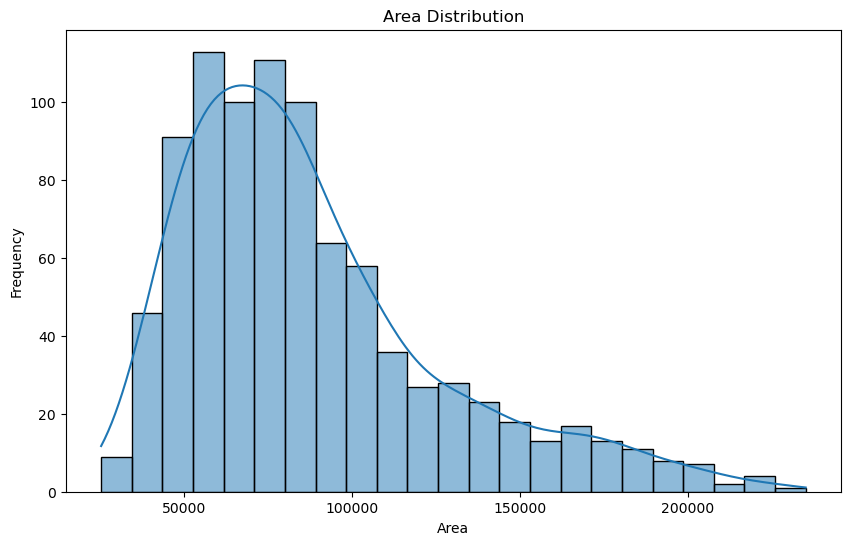

c:\Users\Ixia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


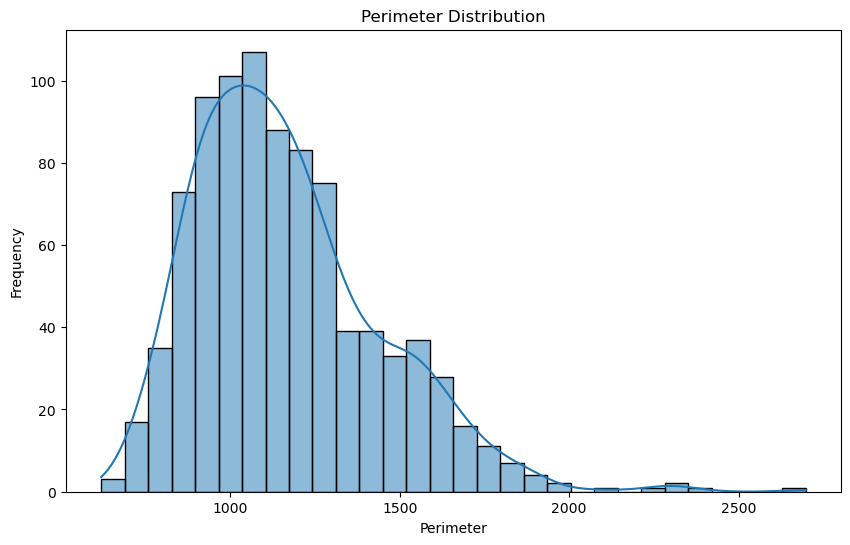

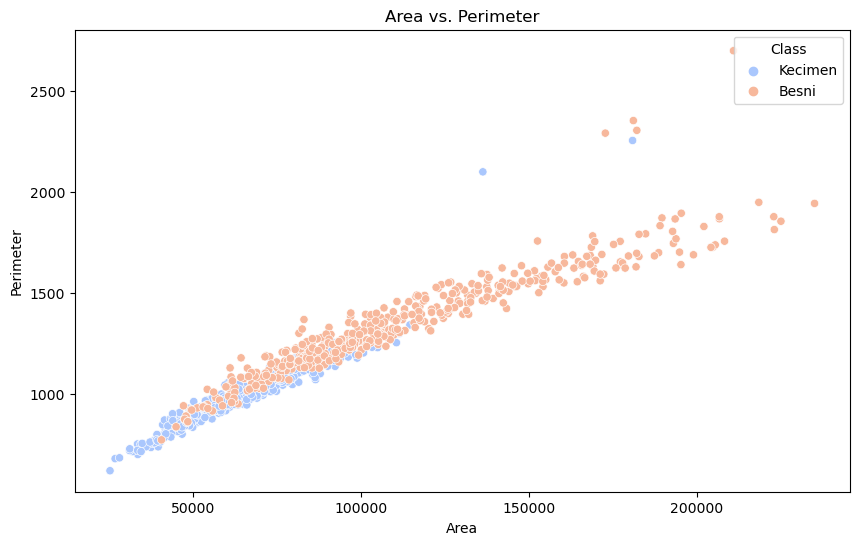

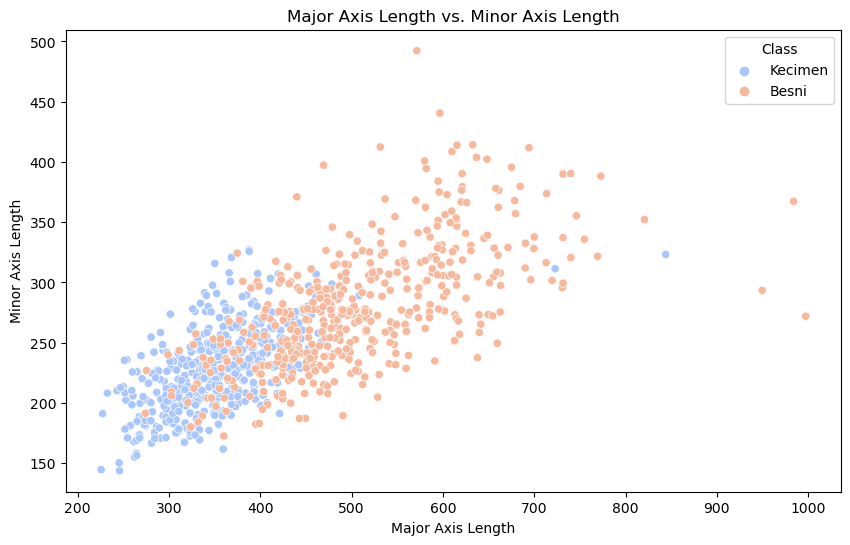

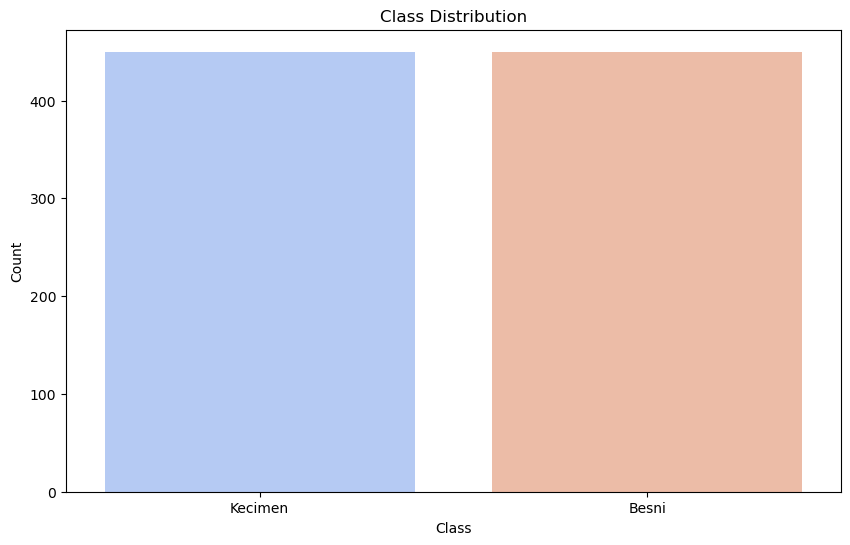

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 6285.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 6285.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 6285.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 6285.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 6285.0
Best run was number 1
Bernoulli Mixture Model with Stochastic EM:
ARI: 0.0
NMI: 0.0
FMI: 0.7067133976895159

K-Modes Clustering:
ARI: 0.0
NMI: 0.002196534775095869
FMI: 0.7059277238527454


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from scipy.io import arff

# Load the dataset from the local ARFF file
file_path = 'Raisin_Dataset/Raisin_Dataset.arff'
data, meta = arff.loadarff(file_path)

# Convert to a pandas DataFrame
df = pd.DataFrame(data)

# Decode byte strings to regular strings for categorical columns (if any)
for column in df.select_dtypes([object]).columns:
    df[column] = df[column].str.decode('utf-8')

# Display the first few rows of the dataframe
df.head()

# Distribution of Area
plt.figure(figsize=(10, 6))
sns.histplot(df['Area'], kde=True)
plt.title('Area Distribution')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.show()

# Distribution of Perimeter
plt.figure(figsize=(10, 6))
sns.histplot(df['Perimeter'], kde=True)
plt.title('Perimeter Distribution')
plt.xlabel('Perimeter')
plt.ylabel('Frequency')
plt.show()

# Area vs. Perimeter
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area', y='Perimeter', hue='Class', palette='coolwarm')
plt.title('Area vs. Perimeter')
plt.xlabel('Area')
plt.ylabel('Perimeter')
plt.show()

# Major Axis Length vs. Minor Axis Length
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='MajorAxisLength', y='MinorAxisLength', hue='Class', palette='coolwarm')
plt.title('Major Axis Length vs. Minor Axis Length')
plt.xlabel('Major Axis Length')
plt.ylabel('Minor Axis Length')
plt.show()

# Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Class', palette='coolwarm')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

from scipy.special import logsumexp

class BernoulliMixtureStochastic:
    def __init__(self, n_components, max_iter, tol=1e-3, batch_size=100):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.batch_size = batch_size
    
    def fit(self, x):
        self.x = x.values if isinstance(x, pd.DataFrame) else x
        self.init_params()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.old_logL = self.get_log_likelihood(log_bernoullis)
        for step in range(self.max_iter):
            if step > 0:
                self.old_logL = self.logL
            idx = np.random.choice(self.n_samples, self.batch_size, replace=False)
            x_batch = self.x[idx]
            log_bernoullis_batch = self.get_log_bernoullis(x_batch)
            self.gamma = self.get_responsibilities(log_bernoullis_batch)
            self.remember_params()
            self.get_Neff()
            self.get_mu(x_batch)
            self.get_pi()
            log_bernoullis = self.get_log_bernoullis(self.x)
            self.logL = self.get_log_likelihood(log_bernoullis)
            if np.isnan(self.logL):
                self.reset_params()
                break
            if abs(self.logL - self.old_logL) < self.tol:
                break

    def reset_params(self):
        self.mu = self.old_mu.copy()
        self.pi = self.old_pi.copy()
        self.gamma = self.old_gamma.copy()
        self.get_Neff()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.logL = self.get_log_likelihood(log_bernoullis)
        
    def remember_params(self):
        self.old_mu = self.mu.copy()
        self.old_pi = self.pi.copy()
        self.old_gamma = self.gamma.copy()
    
    def init_params(self):
        self.n_samples = self.x.shape[0]
        self.n_features = self.x.shape[1]
        self.pi = 1/self.n_components * np.ones(self.n_components)
        self.mu = np.random.RandomState(seed=0).uniform(low=0.25, high=0.75, size=(self.n_components, self.n_features))
        self.normalize_mu()
    
    def normalize_mu(self):
        sum_over_features = np.sum(self.mu, axis=1)
        for k in range(self.n_components):
            self.mu[k,:] /= sum_over_features[k]
            
    def get_responsibilities(self, log_bernoullis):
        gamma = np.zeros(shape=(log_bernoullis.shape[0], self.n_components))
        Z =  logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
        for k in range(self.n_components):
            gamma[:, k] = np.exp(np.log(self.pi[k]) + log_bernoullis[:,k] - Z)
        return gamma
        
    def get_log_bernoullis(self, x):
        log_bernoullis = self.get_save_single(x, self.mu)
        log_bernoullis += self.get_save_single(1-x, 1-self.mu)
        return log_bernoullis
    
    def get_save_single(self, x, mu):
        mu_place = np.where(np.max(mu, axis=0) <= 1e-15, 1e-15, mu)
        return np.tensordot(x, np.log(mu_place), (1,1))
        
    def get_Neff(self):
        self.Neff = np.sum(self.gamma, axis=0)
    
    def get_mu(self, x_batch):
        self.mu = np.einsum('ik,id -> kd', self.gamma, x_batch) / self.Neff[:,None]
        
    def get_pi(self):
        self.pi = self.Neff / self.n_samples
    
    def predict(self, x):
        x = x.values if isinstance(x, pd.DataFrame) else x
        log_bernoullis = self.get_log_bernoullis(x)
        gamma = self.get_responsibilities(log_bernoullis)
        return np.argmax(gamma, axis=1)
        
    def get_sample_log_likelihood(self, log_bernoullis):
        return logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
    
    def get_log_likelihood(self, log_bernoullis):
        return np.mean(self.get_sample_log_likelihood(log_bernoullis))
        
    def score(self, x):
        x = x.values if isinstance(x, pd.DataFrame) else x
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_log_likelihood(log_bernoullis)
    
    def score_samples(self, x):
        x = x.values if isinstance(x, pd.DataFrame) else x
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_sample_log_likelihood(log_bernoullis)

# Encode categorical features as needed
df_encoded = df.drop(columns=["Class"]).apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Initialize and fit the model
model = BernoulliMixtureStochastic(n_components=2, max_iter=100, batch_size=50)
model.fit(df_encoded)

# Predict cluster labels
predicted_labels = model.predict(df_encoded)

from kmodes.kmodes import KModes

km = KModes(n_clusters=2, init='Huang', n_init=5, verbose=1)
kmodes_labels = km.fit_predict(df_encoded)


from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

# Convert class labels to numerical
true_labels = df['Class'].apply(lambda x: 1 if x == 'Kecimen' else 0)

# Performance Metrics for Bernoulli Mixture with Stochastic EM
ari_bms = adjusted_rand_score(true_labels, predicted_labels)
nmi_bms = normalized_mutual_info_score(true_labels, predicted_labels)
fmi_bms = fowlkes_mallows_score(true_labels, predicted_labels)

# Performance Metrics for K-Modes
ari_kmodes = adjusted_rand_score(true_labels, kmodes_labels)
nmi_kmodes = normalized_mutual_info_score(true_labels, kmodes_labels)
fmi_kmodes = fowlkes_mallows_score(true_labels, kmodes_labels)

# Print Results
print("Bernoulli Mixture Model with Stochastic EM:")
print(f"ARI: {ari_bms}")
print(f"NMI: {nmi_bms}")
print(f"FMI: {fmi_bms}")

print("\nK-Modes Clustering:")
print(f"ARI: {ari_kmodes}")
print(f"NMI: {nmi_kmodes}")
print(f"FMI: {fmi_kmodes}")



In [13]:
\documentclass{article}
\usepackage{amsmath}
\usepackage{graphicx}
\usepackage{hyperref}

\title{Comparison of Bernoulli Mixture Model with Stochastic EM and K-Modes Clustering on Raisin Dataset}
\author{Your Name}
\date{\today}

\begin{document}

\maketitle

\begin{abstract}
This report compares the performance of clustering algorithms using Adjusted Rand Index (ARI), Normalized Mutual Information (NMI), and Folkes-Mallows Index (FMI) on the Raisin dataset. The clustering algorithms used are Bernoulli Mixture Model with Stochastic EM and K-Modes.
\end{abstract}

\section{Introduction}
Clustering is a fundamental task in data analysis and pattern recognition. This report evaluates the performance of different clustering algorithms using various clustering performance indices.

\section{Methodology}
The dataset used is the Raisin dataset, which includes seven morphological features. The Bernoulli Mixture Model with Stochastic EM and K-Modes were used for clustering.

\section{Results}
\begin{verbatim}
Bernoulli Mixture Model with Stochastic EM:
ARI: 0.0
NMI: 0.0
FMI: 0.7067133976895159

K-Modes Clustering:
ARI: 0.0
NMI: 0.002196534775095869
FMI: 0.7059277238527454
\end{verbatim}

\section{Discussion}
The results indicate that both the Bernoulli Mixture Model with Stochastic EM and K-Modes Clustering performed similarly in terms of Folkes-Mallows Index (FMI), with values of approximately 0.71. However, the Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) were extremely low for both methods, suggesting poor clustering performance when considering cluster label consistency and mutual information. The high FMI values indicate that the models performed reasonably well in terms of precision and recall, despite the low ARI and NMI scores.

\section{Conclusion}
Both clustering methods show limitations in effectively clustering the Raisin dataset, as indicated by the ARI and NMI scores. The high FMI suggests that while pairwise clustering accuracy is reasonable, the overall cluster structure may not align well with the true labels.

\end{document}


SyntaxError: unexpected character after line continuation character (692092777.py, line 1)